In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
eth_prices = pd.read_csv('ETH-USD.csv')
eth_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,01/01/16,0.9488,0.9488,0.9184,0.9200,0.9200,43
1,02/01/16,0.9200,0.9547,0.9200,0.9547,0.9547,68
2,03/01/16,0.9547,0.9700,0.9506,0.9600,0.9600,485
3,04/01/16,0.9600,0.9644,0.9186,0.9500,0.9500,787
4,05/01/16,0.9500,0.9599,0.9409,0.9426,0.9426,735


In [3]:
ethereum = pd.read_csv('googletrends-ethereum.csv')

ethereum.head()

,Week,ethereum
0,03/01/16,1
1,10/01/16,1
2,17/01/16,1
3,24/01/16,2
4,31/01/16,1


In [4]:
weekly_price = []

for week in ethereum['Week']:
    w = eth_prices.loc[eth_prices['Date'] == week]
    price = w['High'].values
    if len(price) == 0:
        weekly_price.append(np.nan)
    else:
        weekly_price.append(price[0])

In [5]:
ethereum['Price'] = weekly_price

In [17]:
ethereum.tail()

,Week,ethereum,Price
114,11/03/18,21,735.010010
115,18/03/18,20,559.929993
116,25/03/18,21,535.770020
117,01/04/18,17,394.119995
118,08/04/18,15,431.230011


In [18]:
# Drop weeks for which there are missing values 
ethereum = ethereum.dropna(axis=0, how='any')

In [19]:
data = ethereum[['ethereum','Price']].values

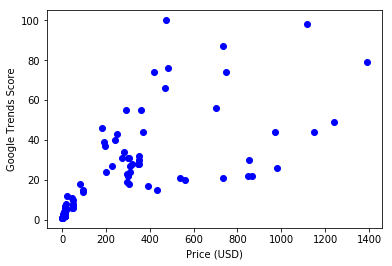

In [20]:
plt.plot(data[:,1],data[:,0], "bo")
plt.xlabel('Price (USD)')
plt.ylabel('Google Trends Score')
plt.show()

In [10]:
# Normalize the data
X = (data[:,1] - np.mean(data[:,1]))/np.std(data[:, 1])
Y = (data[:,0] - np.mean(data[:,0]))/np.std(data[:, 0])

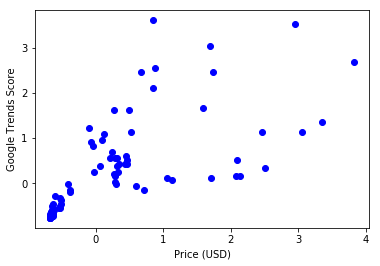

In [11]:
plt.plot(X,Y, "bo")
plt.xlabel('Price (USD)')
plt.ylabel('Google Trends Score')
plt.show()

In [12]:
def simplest_neural_net(x, y, epochs, learning_rate):
    weights = np.array([0, 0])
    bias = 1.
    for e in range(epochs):
        gradient = np.array([0., 0.])
        for i in range(len(x)):
            xi = x[i]
            xi = np.array([bias, xi])
            yi = y[i]
            
            h = np.dot(weights, xi) - yi
            gradient += 2*xi*h
        
        weights = weights - learning_rate*gradient
    return weights[1], weights[0]

In [13]:
# Here the ideal values for slope and y-intercept are converged upon
m, b = simplest_neural_net(X,Y,100, 1e-3)
target_m = m
target_b = b

In [14]:
x_points = np.linspace(np.min(X), np.max(X), 10)
line = b + m*x_points

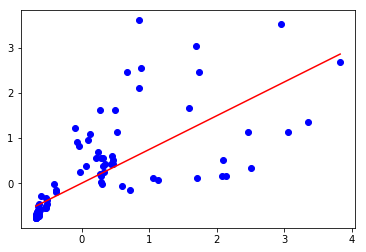

In [15]:
plt.plot(X,Y, 'bo', x_points, line, 'r-')
plt.show()


In [21]:
## Optimizing the learning rate

In [22]:
from sklearn.metrics import mean_squared_error

def evaluation_fxn(x, y, learn_rate, ideal_m, ideal_b):
    x_points = np.linspace(np.min(x), np.max(x), 10)
    ideal_line = ideal_m*x_points + ideal_b
    m, b = simplest_neural_net(x,y,5,learn_rate)
    test_line = m*x_points + b
    
    return 1 - mean_squared_error(ideal_line, test_line)

In [23]:
# Make some inital guesses about the learning rate and evaluate them
# The Gaussian Process will be fit to this data initially.
guesses = [6e-3,1e-3,1e-4]

outcomes = [evaluation_fxn(X,Y,guess, target_m, target_b)
                     for guess in guesses]

In [24]:
from sklearn.gaussian_process import GaussianProcess
import warnings
warnings.filterwarnings('ignore')

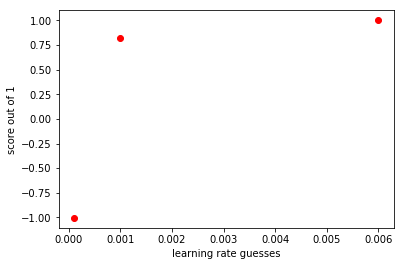

In [25]:
plt.plot(guesses,outcomes,'ro')
plt.xlabel('learning rate guesses')
plt.ylabel('score out of 1')
plt.show()

In [26]:
def hyperparam_selection(guesses, outcomes):
    guesses = np.array(guesses)
    outcomes = np.array(outcomes)
    gp = GaussianProcess(corr='squared_exponential',
                         theta0=1e-1, thetaL=1e-3, thetaU=1)
    
    gp.fit(guesses.reshape((-1,1)), outcomes)
    
    x = np.linspace(np.min(guesses), np.max(guesses), 10)
    
    mean, var = gp.predict(x.reshape((-1,1)), eval_MSE=True)
    std = np.sqrt(var)
    
    expected_improv_lower = mean - 1.96 * std
    expected_improv_upper = mean + 1.96 * std
    
    acquisition_curve = expected_improv_upper - expected_improv_lower
    
    
    idx = acquisition_curve.argmax()
    
    next_param = x[idx]
    
    plt.plot(guesses,outcomes,'ro', label='observations')
    plt.plot(x,mean, 'b--', label='posterior mean')
    plt.plot(x, expected_improv_lower, 'g--', label='variance')
    plt.plot(x, expected_improv_upper, 'g--')
    plt.plot(x, acquisition_curve, 'k--', label='acquisition fxn')
    plt.plot(x[idx],acquisition_curve[idx], 'yX', label='next guess')
    plt.xlabel('learning rate')
    plt.ylabel('score out of 1')
    plt.legend(loc='best')
    plt.show()
    
    return next_param

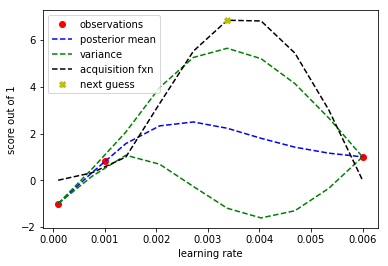

('Suggested learning rate: ', 0.0033777777777777773)


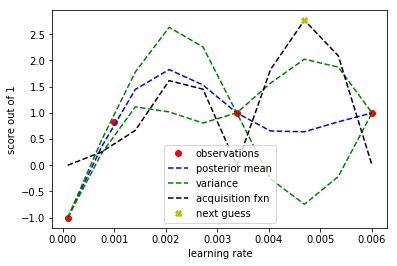

('Suggested learning rate: ', 0.0046888888888888891)


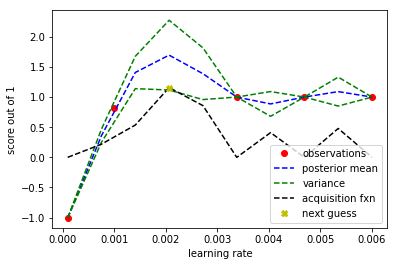

('Suggested learning rate: ', 0.0020666666666666663)


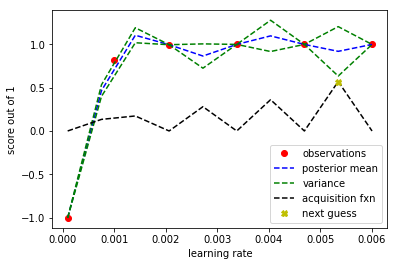

('Suggested learning rate: ', 0.0053444444444444442)


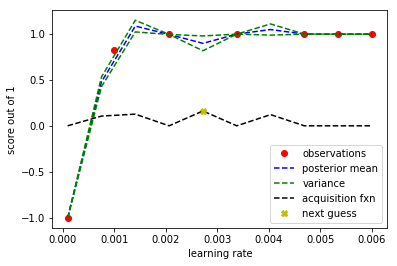

('Suggested learning rate: ', 0.0027222222222222218)


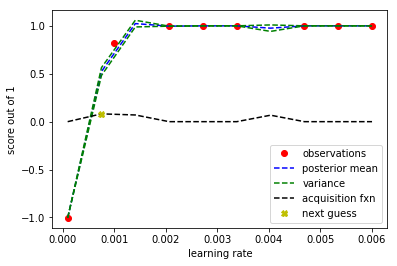

('Suggested learning rate: ', 0.00075555555555555554)


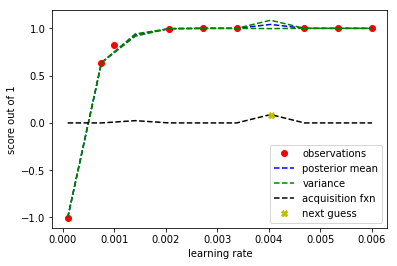

('Suggested learning rate: ', 0.0040333333333333332)


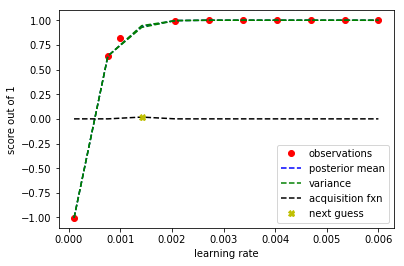

('Suggested learning rate: ', 0.001411111111111111)


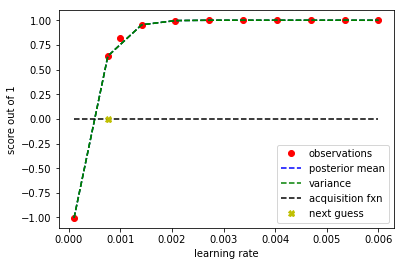

('Suggested learning rate: ', 0.00075555555555555554)
optimal learning rate found


In [27]:
for _ in range(10):
    
    try:
        new_learning_rate = hyperparam_selection(guesses,outcomes) 
    except:
        print("optimal learning rate found")
        break
    
    guesses.append(new_learning_rate)
    score = evaluation_fxn(X,Y,new_learning_rate, target_m, target_b)
    print("Suggested learning rate: ",new_learning_rate)
    outcomes.append(score)

In [28]:
# Here we found an optimizated learning rate by using an acquisition function. 
# This acquisition function identified the next guess for the hyperparameter by 
# taking the posterior mean plus a constant times the variance.